# Handwash Full Pipeline (Kaggle)
Self contained notebook for Kaggle.


In [1]:
# Install dependencies
!pip install -q --no-cache-dir scikit-learn pandas numpy opencv-python-headless matplotlib seaborn tqdm requests gdown zenodo-get ipython


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from tensorflow import keras
# =========================
# Standard library
# =========================
import math
import random
from pathlib import Path
from typing import List, Dict, Tuple

# =========================
# Third-party
# =========================
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm

# =========================
# TensorFlow / Keras  ← THIS IS WHAT YOU ARE MISSING
# =========================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2026-01-03 21:32:46.218394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767475966.725378      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767475966.860185      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767475968.007160      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767475968.007206      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767475968.007209      24 computation_placer.cc:177] computation placer alr

In [3]:
import os, sys, json, time, math, random, shutil, subprocess
from pathlib import Path

RUN_NAME = os.environ.get("RUN_NAME", "handwash_run")
WORK_DIR = Path("/kaggle/working/handwash_runs") / RUN_NAME
DATA_DIR = Path("/kaggle/working/handwash_data")

RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
MODELS_DIR = WORK_DIR / "models"
CKPT_DIR = WORK_DIR / "checkpoints"
LOGS_DIR = WORK_DIR / "logs"

for p in [WORK_DIR, DATA_DIR, RAW_DIR, PROCESSED_DIR, MODELS_DIR, CKPT_DIR, LOGS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))
print("Note: Enable internet in Kaggle if downloads fail.")


TensorFlow: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Note: Enable internet in Kaggle if downloads fail.


## Configuration
All options are user editable.


In [4]:
# User config (edit these)
DATASETS = ["metc"]

AVAILABLE_FRAME_MODELS = [
    "mobilenetv2",
    "resnet50",
    "resnet101",
    "resnet152",
    "efficientnetb0",
    "efficientnetb3",
    "efficientnetv2b0",
    "convnext_tiny",
    "vit_b16",
]
AVAILABLE_SEQUENCE_MODELS = ["lstm", "gru", "3d_cnn"]

MODELS = ["mobilenetv2"]

IMG_SIZE = (224, 224)
NUM_CLASSES = 7
CLASS_NAMES = [
    "Other",
    "Step1_PalmToPalm",
    "Step2_PalmOverDorsum",
    "Step3_InterlacedFingers",
    "Step4_BackOfFingers",
    "Step5_ThumbRub",
    "Step6_Fingertips",
]
PSKUS_CODE_MAPPING = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 0,
}


FRAME_SKIP = 2
SEQUENCE_LENGTH = 16
SEQUENCE_STRIDE = 1
MAX_SEQUENCES_PER_VIDEO = 200

EPOCHS = 250
LR = 1e-4
BATCH_MOBILENET = 128
BATCH_SEQUENCE = 64
AUTO_TUNE_BATCH = True
MIXED_PRECISION = True
TB_PORT = 6008
RESUME_MODEL_PATHS ={}
RECOMPILE_ON_RESUME = False  # set True to reset optimizer/LR on resume


# Optimizer + loss
OPTIMIZER_NAME = "adamw"
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.0

# ResNet50 fine-tuning schedule
RESNET50_SCHEDULE = True
RESNET50_STAGE0_EPOCHS = 5
RESNET50_STAGE1_EPOCHS = 10
RESNET50_STAGE2_EPOCHS = 20
RESNET50_STAGE0_LR = 3e-4
RESNET50_STAGE1_LR = 1e-4
RESNET50_STAGE2_LR = 3e-5
RESNET50_STAGE0_WD = 1e-4
RESNET50_STAGE1_WD = 1e-4
RESNET50_STAGE2_WD = 5e-5

# Augmentation
USE_OFFLINE_AUGMENT = True  # generate augmented samples on disk
USE_ON_THE_FLY_AUGMENT = False  # apply aug during loading
AUGMENT_MULTIPLIER = 3  # how many total samples per original (1 = none)
AUGMENT_MAX_PER_SAMPLE = 1  # cap for offline augment per original
AUGMENT_PROB = None  # 0-1 ratio; None derives from AUGMENT_MULTIPLIER
CONSISTENT_VIDEO_AUG = True  # keep the same aug per video
AUGMENT_CONFIG = {
    "rotation": 15,
    "zoom": 0.15,
    "shift": 0.1,
    "shear": 0.1,
    "brightness": (0.8, 1.2),
    "contrast": (0.8, 1.2),
    "gamma": (0.8, 1.2),
    "hflip": True,
    "mid_flip": True,
    "shadow": True,
    "reverse_sequence": True,
}

# Reporting
SHOW_CONFUSION_MATRICES = True
CONFUSION_NORMALIZE = False
EVAL_TEST_EACH_EPOCH = True

# Cleanup
SKIP_DOWNLOAD_IF_PRESENT = True
CLEANUP_RAW = True
CLEANUP_TRAIN = True
KEEP_VAL_TEST = True

# Dataset sources
KAGGLE_URL = "https://github.com/atiselsts/data/raw/master/kaggle-dataset-6classes.tar"
PSKUS_ZENODO = "4537209"
METC_ZENODO = "5808789"
SYNTHETIC_LINKS = [
    "https://drive.google.com/uc?id=1EW3JQvElcuXzawxEMRkA8YXwK_Ipiv-p&export=download",
    "https://drive.google.com/uc?id=163TsrDe4q5KTQGCv90JRYFkCs7AGxFip&export=download",
    "https://drive.google.com/uc?id=1GxyTYfSodumH78NbjWdmbjm8JP8AOkAY&export=download",
    "https://drive.google.com/uc?id=1IoRsgBBr8qoC3HO-vEr6E7K4UZ6ku6-1&export=download",
    "https://drive.google.com/uc?id=1svCYnwDazy5FN1DYSgqbGscvDKL_YnID&export=download",
]

print("Datasets:", DATASETS)
print("Models:", MODELS)


Datasets: ['metc']
Models: ['mobilenetv2']


In [5]:
# Auto-tune and mixed precision
if MIXED_PRECISION:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision enabled")


def get_gpu_mem_mb():
    try:
        out = subprocess.check_output([
            "nvidia-smi",
            "--query-gpu=memory.total",
            "--format=csv,noheader,nounits",
        ])
        return int(out.decode().strip().splitlines()[0])
    except Exception:
        return 0

if AUTO_TUNE_BATCH:
    mem_mb = get_gpu_mem_mb()
    if mem_mb > 0:
        BATCH_MOBILENET = max(64, min(256, int(mem_mb / 120)))
        BATCH_SEQUENCE = max(32, min(128, int(mem_mb / 240)))
        print("Auto batch sizes:", BATCH_MOBILENET, BATCH_SEQUENCE)
    else:
        print("GPU memory not detected; using configured batches")


Mixed precision enabled
Auto batch sizes: 128 64


In [6]:
# Start TensorBoard (logs only; Kaggle does not expose ports)
import subprocess

tb_proc = subprocess.Popen([
    "tensorboard",
    "--logdir", str(LOGS_DIR),
    "--host", "0.0.0.0",
    "--port", str(TB_PORT),
    "--load_fast=false",
], stdout=open(LOGS_DIR / "tensorboard.out", "w"), stderr=subprocess.STDOUT)

print("TensorBoard PID:", tb_proc.pid)
print("Logs:", LOGS_DIR)


TensorBoard PID: 70
Logs: /kaggle/working/handwash_runs/handwash_run/logs


In [7]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/handwash_runs --host 0.0.0.0 --port 6008


ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
/usr/local/lib/python3.12/dist-packages/tensorboard/_vendor/bleach/sanitizer.py:292: SyntaxWarning: invalid escape sequence '\s'
  "[`\000-\040\177-\240\s]+",
/usr/local/lib/python3.12/dist-packages/tensorboard/_vendor/bleach/sanitizer.py:339: SyntaxWarning: invalid escape sequence '\s'
  style = re.compile('url\s*\(\s*[^\s)]+?\s*\)\s*').sub(' ', style)
/usr/local/lib/python3.12/dist-packages/tensorboard/_vendor/bleach/sanitizer.py:354: SyntaxWarning: invalid escape sequence '\s'
  if not re.match("^\s*([-\w]+\s*:[^:;]*(;\s*|$))*$", style):
/usr/local/lib/python3.12/dist-packages/tensorboard/_vendor/bleach/sanitizer.py:358: SyntaxWarning: invalid escape sequence '\w'
  for prop, value in re.findall('([-\w]+)\s*:\s*([^:;]*)', style):
2026-01-03 21:33:11.053981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 

## Download and preprocess


In [8]:
import requests
from tqdm import tqdm
import tarfile, zipfile
from IPython.display import Video, display

LABEL_TOKENS = {
    "step1": 1,
    "step2": 2,
    "step3": 3,
    "step4": 4,
    "step5": 5,
    "step6": 6,
    "other": 0,
}

VIDEO_EXTS = (".mp4", ".avi", ".mov", ".mkv")
IMAGE_EXTS = (".jpg", ".jpeg", ".png")


def download_with_progress(url: str, dest: Path):
    dest.parent.mkdir(parents=True, exist_ok=True)
    if dest.exists():
        print("skip", dest)
        return
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        with open(dest, "wb") as f, tqdm(total=total, unit="B", unit_scale=True, desc=dest.name) as pbar:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))


def extract_tar(tar_path: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    with tarfile.open(tar_path) as tfp:
        tfp.extractall(out_dir)
    tar_path.unlink(missing_ok=True)


def extract_zip(zip_path: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path) as zf:
        zf.extractall(out_dir)
    zip_path.unlink(missing_ok=True)


def download_kaggle():
    out_dir = RAW_DIR / "kaggle"
    out_dir.mkdir(parents=True, exist_ok=True)
    tar_path = out_dir / "kaggle-dataset-6classes.tar"
    download_with_progress(KAGGLE_URL, tar_path)
    print("Extracting kaggle...")
    extract_tar(tar_path, out_dir)
    return out_dir


def download_zenodo(zenodo_id: str, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    cmd = ["zenodo_get", "-r", zenodo_id, "-o", str(out_dir)]
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)
    zip_files = sorted(out_dir.glob("*.zip"))
    tar_files = sorted(out_dir.glob("*.tar*"))
    if zip_files or tar_files:
        print("Extracting Zenodo archives...")
    for zip_file in zip_files:
        extract_zip(zip_file, out_dir)
    for tar_file in tar_files:
        extract_tar(tar_file, out_dir)
    return out_dir


def download_pskus():
    return download_zenodo(PSKUS_ZENODO, RAW_DIR / "pskus")


def download_metc():
    return download_zenodo(METC_ZENODO, RAW_DIR / "metc")


def download_synthetic():
    out_dir = RAW_DIR / "synthetic_blender_rozakar"
    out_dir.mkdir(parents=True, exist_ok=True)
    for i, link in enumerate(SYNTHETIC_LINKS, 1):
        out_zip = out_dir / f"synth_{i}.zip"
        if not out_zip.exists():
            subprocess.check_call(["gdown", "-q", link, "-O", str(out_zip)])
        extract_zip(out_zip, out_dir)
    return out_dir

def _extract_archives_if_needed(raw_dir: Path):
    zip_files = sorted(raw_dir.glob("*.zip"))
    tar_files = sorted(raw_dir.glob("*.tar*"))
    if zip_files or tar_files:
        print("Extracting existing archives in", raw_dir)
    for zip_file in zip_files:
        extract_zip(zip_file, raw_dir)
    for tar_file in tar_files:
        extract_tar(tar_file, raw_dir)



def ensure_dataset(name: str):
    raw_dir = RAW_DIR / name
    if raw_dir.exists():
        _extract_archives_if_needed(raw_dir)
        if SKIP_DOWNLOAD_IF_PRESENT:
            print("skip download, exists", raw_dir)
            return raw_dir
    if name == "kaggle":
        return download_kaggle()
    if name == "pskus":
        return download_pskus()
    if name == "metc":
        return download_metc()
    if name == "synthetic_blender_rozakar":
        return download_synthetic()
    raise ValueError("Unknown dataset " + name)


In [9]:
import numpy as np
import cv2
import pandas as pd
import json
import csv
import re
from typing import List, Dict, Optional
from sklearn.model_selection import train_test_split
from IPython.display import Video, display
from tqdm import tqdm


def infer_label_from_path(p: Path) -> int:
    parts = [part for part in Path(p).parts]
    for part in reversed(parts):
        if part.isdigit():
            class_id = int(part)
            if 0 <= class_id < len(CLASS_NAMES):
                return class_id
    text = str(p).lower()
    for token, idx in LABEL_TOKENS.items():
        if token in text:
            return idx
    return 0


SYNTHETIC_GESTURE_TO_CLASS = {
    1: 1,
    2: 2,
    3: 2,
    4: 3,
    5: 4,
    6: 5,
    7: 5,
    8: 6,
}


def _parse_int_from_text(text: str) -> int | None:
    match = re.search(r"(\d+)", text)
    return int(match.group(1)) if match else None


def infer_synthetic_class_id(path: Path) -> int | None:
    for part in path.parts:
        if "gesture" in part.lower():
            num = _parse_int_from_text(part)
            if num is None:
                continue
            return SYNTHETIC_GESTURE_TO_CLASS.get(num)
    return None


def synthetic_video_id(path: Path) -> str:
    parts = list(path.parts)
    gesture_idx = None
    for i, part in enumerate(parts):
        if part.lower().startswith("gesture"):
            gesture_idx = i
    if gesture_idx is None or gesture_idx < 2:
        return path.stem
    character = parts[gesture_idx - 2]
    environment = parts[gesture_idx - 1]
    gesture = parts[gesture_idx]
    return f"{character}_{environment}_{gesture}"


def parse_frame_idx(path: Path) -> int:
    num = _parse_int_from_text(path.stem)
    return int(num) if num is not None else 0


def _majority_vote(labels, total_movements):
    counts = [0] * total_movements
    for el in labels:
        counts[int(el)] += 1
    best = 0
    for i in range(1, total_movements):
        if counts[best] < counts[i]:
            best = i
    majority = (len(labels) + 2) // 2
    if counts[best] < majority:
        return -1
    return best


def _discount_reaction_indeterminacy(labels, reaction_frames):
    new_labels = [u for u in labels]
    n = len(labels) - 1
    for i in range(n):
        if i == 0 or labels[i] != labels[i + 1] or i == n - 1:
            start = max(0, i - reaction_frames)
            end = i
            for j in range(start, end):
                new_labels[j] = -1
            start = i
            end = min(n + 1, i + reaction_frames)
            for j in range(start, end):
                new_labels[j] = -1
    return new_labels


def _select_frames_to_save(is_washing, codes, movement0_prop=1.0):
    old_code = -1
    old_saved = False
    num_snippets = 0
    mapping = {}
    current_snippet = {}
    for i in range(len(is_washing)):
        new_code = codes[i]
        new_saved = (is_washing[i] == 2 and new_code != -1)
        if new_saved != old_saved:
            if new_saved:
                num_snippets += 1
                current_snippet = {}
            else:
                if old_code != 0 or np.random.rand() < movement0_prop:
                    for key in current_snippet:
                        mapping[key] = current_snippet[key]
        if new_saved:
            current_snippet_frame = len(current_snippet)
            current_snippet[i] = (current_snippet_frame, num_snippets, new_code)
        old_saved = new_saved
        old_code = new_code
    if old_saved:
        if old_code != 0 or np.random.rand() < movement0_prop:
            for key in current_snippet:
                mapping[key] = current_snippet[key]
    return mapping


def _find_annotations_dir(video_path: Path) -> Path | None:
    for parent in video_path.parents:
        ann_dir = parent / "Annotations"
        if ann_dir.exists():
            return ann_dir
    return None


def _load_frame_annotations(video_path: Path, annotator_prefix: str, total_annotators: int):
    ann_dir = _find_annotations_dir(video_path)
    if not ann_dir:
        return [], 0
    annotations = []
    for a in range(1, total_annotators + 1):
        annotator_dir = ann_dir / f"{annotator_prefix}{a}"
        json_path = annotator_dir / f"{video_path.stem}.json"
        if not json_path.exists():
            continue
        try:
            with open(json_path, "r") as f:
                data = json.load(f)
            a_annotations = [(data['labels'][i]['is_washing'], data['labels'][i]['code']) for i in range(len(data['labels']))]
            annotations.append(a_annotations)
        except Exception as exc:
            print("Failed to load", json_path, exc)
    return annotations, len(annotations)


def _frame_labels_from_annotations(annotations, total_movements, reaction_frames):
    num_annotators = len(annotations)
    if num_annotators == 0:
        return [], []
    num_frames = len(annotations[0])
    is_washing, codes = [], []
    for frame_num in range(num_frames):
        frame_annotations = [annotations[a][frame_num] for a in range(num_annotators)]
        frame_is_washing_any = any(frame_annotations[a][0] for a in range(num_annotators))
        frame_is_washing_all = all(frame_annotations[a][0] for a in range(num_annotators))
        frame_codes = [frame_annotations[a][1] for a in range(num_annotators)]
        frame_codes = [PSKUS_CODE_MAPPING.get(int(code), 0) for code in frame_codes]
        if frame_is_washing_all:
            frame_is_washing = 2
        elif frame_is_washing_any:
            frame_is_washing = 1
        else:
            frame_is_washing = 0
        is_washing.append(frame_is_washing)
        if frame_is_washing:
            codes.append(_majority_vote(frame_codes, total_movements))
        else:
            codes.append(-1)
    is_washing = _discount_reaction_indeterminacy(is_washing, reaction_frames)
    codes = _discount_reaction_indeterminacy(codes, reaction_frames)
    return is_washing, codes


def _load_pskus_split(pskus_dir: Path):
    csv_path = pskus_dir / "statistics-with-locations.csv"
    if not csv_path.exists():
        candidates = [
            Path.cwd() / "code/edgewash/dataset-pskus/statistics-with-locations.csv",
            Path.cwd() / "edgeWash/code/edgewash/dataset-pskus/statistics-with-locations.csv",
        ]
        for candidate in candidates:
            if candidate.exists():
                csv_path = candidate
                print("Using fallback PSKUS split file:", csv_path)
                break
    if not csv_path.exists():
        print("PSKUS split CSV not found; will use random split later")
        return set(), set()
    testfiles, trainvalfiles = set(), set()
    try:
        with open(csv_path, "r") as csv_file:
            reader = csv.reader(csv_file)
            for row in reader:
                if row and row[0] == "filename":
                    continue
                if not row:
                    continue
                filename = row[0]
                location = row[1] if len(row) > 1 else ""
                if location == "Reanimācija":
                    testfiles.add(filename)
                elif location != "unknown":
                    trainvalfiles.add(filename)
    except Exception as exc:
        print("Failed to read PSKUS split CSV", csv_path, exc)
    return testfiles, trainvalfiles


def extract_frames_from_video(video_path: Path, out_dir: Path, frame_skip: int) -> List[Dict]:
    rows = []
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        return rows
    base = video_path.stem
    label = infer_label_from_path(video_path)
    idx = 0
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_skip == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, IMG_SIZE)
            out_path = out_dir / f"{base}_{idx:06d}.jpg"
            cv2.imwrite(str(out_path), frame[:, :, ::-1])
            rows.append({"frame_path": str(out_path), "class_id": label, "video_id": base, "frame_idx": idx})
            idx += 1
        frame_idx += 1
    cap.release()
    return rows


def preprocess_images(image_paths: List[Path], out_dir: Path) -> List[Dict]:
    rows = []
    out_dir.mkdir(parents=True, exist_ok=True)
    for img_path in tqdm(image_paths, desc="images"):
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        label = infer_label_from_path(img_path)
        out_path = out_dir / f"{img_path.stem}.jpg"
        cv2.imwrite(str(out_path), img[:, :, ::-1])
        rows.append({"frame_path": str(out_path), "class_id": label, "video_id": img_path.parent.name, "frame_idx": 0})
    return rows


def _split_train_val_by_video(df, train_ratio=0.7, val_ratio=0.15):
    unique_videos = df["video_id"].unique()
    video_to_class = df.groupby("video_id")["class_id"].first()
    val_size = val_ratio / (train_ratio + val_ratio)
    train_videos, val_videos = train_test_split(
        unique_videos,
        test_size=val_size,
        random_state=42,
        stratify=video_to_class[unique_videos],
    )
    train_df = df[df["video_id"].isin(train_videos)].reset_index(drop=True)
    val_df = df[df["video_id"].isin(val_videos)].reset_index(drop=True)
    return train_df, val_df


def split_and_save(df: pd.DataFrame, out_dir: Path) -> Dict[str, Path]:
    if "split" in df.columns and df["split"].notna().any():
        test_df = df[df["split"] == "test"].reset_index(drop=True)
        trainval_df = df[df["split"] != "test"].reset_index(drop=True)
        if not trainval_df.empty:
            train_df, val_df = _split_train_val_by_video(trainval_df)
        else:
            train_df, val_df = df, df.iloc[0:0].copy()
    else:
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        n = len(df)
        train_end = int(0.7 * n)
        val_end = int(0.85 * n)
        train_df, val_df, test_df = df.iloc[:train_end], df.iloc[train_end:val_end], df.iloc[val_end:]
    out_dir.mkdir(parents=True, exist_ok=True)
    train_csv = out_dir / "train.csv"
    val_csv = out_dir / "val.csv"
    test_csv = out_dir / "test.csv"
    train_df.to_csv(train_csv, index=False)
    val_df.to_csv(val_csv, index=False)
    test_df.to_csv(test_csv, index=False)
    return {"train": train_csv, "val": val_csv, "test": test_csv}


def preprocess_pskus_dataset(pskus_dir: Path, frames_root: Path) -> pd.DataFrame:
    rows = []
    testfiles, trainvalfiles = _load_pskus_split(pskus_dir)
    has_split = bool(testfiles or trainvalfiles)
    movement0_prop = 0.2
    total_annotators = 8
    total_movements = 8
    fps = 30
    reaction_frames = fps // 2

    for video_path in pskus_dir.rglob("*.mp4"):
        filename = video_path.name
        if has_split:
            if filename in testfiles:
                split = "test"
            elif filename in trainvalfiles:
                split = "trainval"
            else:
                continue
        else:
            split = None

        annotations, num_annotators = _load_frame_annotations(video_path, "Annotator", total_annotators)
        if num_annotators <= 1:
            continue
        is_washing, codes = _frame_labels_from_annotations(annotations, total_movements, reaction_frames)
        mapping = _select_frames_to_save(is_washing, codes, movement0_prop)
        if not mapping:
            continue
        frames_dir = frames_root / (split or "trainval")
        vidcap = cv2.VideoCapture(str(video_path))
        is_success, image = vidcap.read()
        frame_number = 0
        while is_success:
            if frame_number in mapping:
                new_frame_num, snippet_num, code = mapping[frame_number]
                out_sub = frames_dir / str(code)
                out_sub.mkdir(parents=True, exist_ok=True)
                filename_out = f"frame_{new_frame_num}_snippet_{snippet_num}_{video_path.stem}.jpg"
                save_path = out_sub / filename_out
                image_resized = cv2.resize(image, IMG_SIZE)
                cv2.imwrite(str(save_path), image_resized)
                row = {
                    "frame_path": str(save_path),
                    "class_id": int(code),
                    "video_id": video_path.stem,
                    "frame_idx": new_frame_num,
                }
                if split:
                    row["split"] = split
                rows.append(row)
            is_success, image = vidcap.read()
            frame_number += 1
        vidcap.release()
    return pd.DataFrame(rows)


def preprocess_metc_dataset(metc_dir: Path, frames_root: Path) -> pd.DataFrame:
    rows = []
    total_annotators = 1
    total_movements = 7
    fps = 16
    reaction_frames = fps // 2
    test_proportion = 0.25
    for video_path in metc_dir.rglob("*.mp4"):
        split = "test" if np.random.rand() < test_proportion else "trainval"
        annotations, num_annotators = _load_frame_annotations(video_path, "Annotator_", total_annotators)
        if num_annotators == 0:
            continue
        is_washing, codes = _frame_labels_from_annotations(annotations, total_movements, reaction_frames)
        mapping = _select_frames_to_save(is_washing, codes, movement0_prop=1.0)
        if not mapping:
            continue
        frames_dir = frames_root / split
        vidcap = cv2.VideoCapture(str(video_path))
        is_success, image = vidcap.read()
        frame_number = 0
        while is_success:
            if frame_number in mapping:
                new_frame_num, snippet_num, code = mapping[frame_number]
                out_sub = frames_dir / str(code)
                out_sub.mkdir(parents=True, exist_ok=True)
                filename_out = f"frame_{new_frame_num}_snippet_{snippet_num}_{video_path.stem}.jpg"
                save_path = out_sub / filename_out
                image_resized = cv2.resize(image, IMG_SIZE)
                cv2.imwrite(str(save_path), image_resized)
                rows.append({
                    "frame_path": str(save_path),
                    "class_id": int(code),
                    "video_id": video_path.stem,
                    "frame_idx": new_frame_num,
                    "split": split,
                })
            is_success, image = vidcap.read()
            frame_number += 1
        vidcap.release()
    return pd.DataFrame(rows)




def preprocess_synthetic_dataset(raw_dir: Path, frames_root: Path) -> pd.DataFrame:
    rows = []
    frames_root.mkdir(parents=True, exist_ok=True)
    image_paths = [p for p in raw_dir.rglob("*.png") if p.is_file()]
    for img_path in tqdm(image_paths, desc="synthetic"):
        if "rgb" not in [part.lower() for part in img_path.parts]:
            continue
        class_id = infer_synthetic_class_id(img_path)
        if class_id is None:
            continue
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        video_id = synthetic_video_id(img_path)
        frame_idx = parse_frame_idx(img_path)
        out_sub = frames_root / str(class_id)
        out_sub.mkdir(parents=True, exist_ok=True)
        out_path = out_sub / f"{video_id}_{frame_idx:06d}.jpg"
        cv2.imwrite(str(out_path), img[:, :, ::-1])
        rows.append({
            "frame_path": str(out_path),
            "class_id": int(class_id),
            "video_id": video_id,
            "frame_idx": int(frame_idx),
        })
    return pd.DataFrame(rows)



def _is_archive(path: Path) -> bool:
    name = path.name.lower()
    return name.endswith((".zip", ".tar", ".tar.gz", ".tgz", ".tar.bz2", ".tar.xz"))


def _collect_archives(root: Path, max_hits: int = 5):
    hits = []
    if not root.exists():
        return hits
    for path in root.rglob("*"):
        if path.is_file() and _is_archive(path):
            hits.append(path)
            if len(hits) >= max_hits:
                break
    return hits


def _iter_files(root: Path, exts, max_hits: int = 3):
    hits = []
    if not root.exists():
        return hits
    for path in root.rglob("*"):
        if path.is_file() and path.suffix.lower() in exts:
            hits.append(path)
            if len(hits) >= max_hits:
                break
    return hits


def _find_pskus_split_csv(raw_dir: Path):
    csv_path = raw_dir / "statistics-with-locations.csv"
    if csv_path.exists():
        return csv_path
    candidates = [
        Path.cwd() / "code/edgewash/dataset-pskus/statistics-with-locations.csv",
        Path.cwd() / "edgeWash/code/edgewash/dataset-pskus/statistics-with-locations.csv",
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    return None


def validate_raw_dataset(name: str, raw_dir: Path, strict_archives: bool = True) -> None:
    errors = []
    if not raw_dir.exists():
        errors.append("raw dir missing")
    elif name == "kaggle":
        kaggle_root = raw_dir / "kaggle-dataset-6classes"
        if not kaggle_root.exists():
            errors.append("kaggle-dataset-6classes folder missing")
        if not _iter_files(kaggle_root, VIDEO_EXTS):
            errors.append("no videos found under kaggle-dataset-6classes")
    elif name == "pskus":
        dataset_dirs = [p for p in raw_dir.rglob("DataSet*") if p.is_dir()]
        if not dataset_dirs:
            errors.append("no DataSet* folders found")
        if not _iter_files(raw_dir, VIDEO_EXTS):
            errors.append("no videos found")
        if not _iter_files(raw_dir, (".json",), max_hits=1):
            errors.append("no annotation JSON files found")
        if _find_pskus_split_csv(raw_dir) is None:
            errors.append("statistics-with-locations.csv not found")
    elif name == "metc":
        interface_dirs = [p for p in raw_dir.rglob("Interface_number_*") if p.is_dir()]
        if not interface_dirs:
            errors.append("no Interface_number_* folders found")
        if not _iter_files(raw_dir, VIDEO_EXTS):
            errors.append("no videos found")
        if not _iter_files(raw_dir, (".json",), max_hits=1):
            errors.append("no annotation JSON files found")
    elif name == "synthetic_blender_rozakar":
        pngs = _iter_files(raw_dir, (".png",), max_hits=3)
        if not pngs:
            errors.append("no PNG files found")
    else:
        errors.append("unknown dataset name")

    archives = _collect_archives(raw_dir)
    if archives:
        msg = "archive files still present: " + ", ".join([p.name for p in archives])
        if strict_archives:
            errors.append(msg)
        else:
            print("WARN:", msg)

    if errors:
        raise RuntimeError(f"Raw dataset validation failed for {name}: " + "; ".join(errors))


def validate_processed_dataset(out_dir: Path, max_rows: int = 20) -> None:
    errors = []
    for split in ("train", "val", "test"):
        csv_path = out_dir / f"{split}.csv"
        if not csv_path.exists():
            errors.append(f"missing {split}.csv")
            continue
        df = pd.read_csv(csv_path).head(max_rows)
        if df.empty:
            errors.append(f"{split}.csv has no rows")
            continue
        required = {"frame_path", "class_id", "video_id", "frame_idx"}
        missing = required - set(df.columns)
        if missing:
            errors.append(f"{split}.csv missing columns: {sorted(missing)}")
            continue
        for row in df.itertuples():
            frame_path = Path(row.frame_path)
            if not frame_path.exists():
                errors.append(f"missing frame file: {frame_path}")
                break
            if not (0 <= int(row.class_id) < NUM_CLASSES):
                errors.append(f"class_id out of range: {row.class_id}")
                break
    if errors:
        raise RuntimeError("Processed dataset validation failed: " + "; ".join(errors))

def preprocess_dataset(name: str) -> Path:
    raw_dir = RAW_DIR / name
    out_dir = PROCESSED_DIR / name
    frames_dir = out_dir / "frames"
    frames_dir.mkdir(parents=True, exist_ok=True)

    if name == "pskus":
        df = preprocess_pskus_dataset(raw_dir, frames_dir)
    elif name == "metc":
        df = preprocess_metc_dataset(raw_dir, frames_dir)
    elif name == "synthetic_blender_rozakar":
        df = preprocess_synthetic_dataset(raw_dir, frames_dir)
    else:
        video_files = [p for p in raw_dir.rglob("*") if p.suffix.lower() in VIDEO_EXTS]
        image_files = [p for p in raw_dir.rglob("*") if p.suffix.lower() in IMAGE_EXTS]
        rows = []
        if video_files:
            for vp in tqdm(video_files, desc="videos"):
                rows.extend(extract_frames_from_video(vp, frames_dir, FRAME_SKIP))
        elif image_files:
            rows.extend(preprocess_images(image_files, frames_dir))
        else:
            raise RuntimeError("No video or image files found in " + str(raw_dir))
        df = pd.DataFrame(rows)

    if df.empty:
        raise RuntimeError("No frames extracted for " + name)
    split_and_save(df, out_dir)
    return out_dir


def show_random_video(raw_dir: Path):
    videos = [p for p in raw_dir.rglob("*") if p.suffix.lower() in VIDEO_EXTS]
    if not videos:
        print("No videos found")
        return
    print("Video sample:", videos[0])
    display(Video(str(videos[0]), embed=True))


def show_random_samples(df: pd.DataFrame, title: str, n: int = 12):
    import matplotlib.pyplot as plt
    sample = df.sample(n, replace=True)
    plt.figure(figsize=(12, 6))
    for i, row in enumerate(sample.itertuples(), 1):
        img = cv2.imread(row.frame_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 4, i)
        plt.imshow(img)
        label = CLASS_NAMES[int(row.class_id)] if int(row.class_id) < len(CLASS_NAMES) else str(row.class_id)
        plt.title(label, fontsize=8)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def print_class_distribution(df: pd.DataFrame, label: str) -> None:
    col = "class_name" if "class_name" in df.columns else "class_id"
    counts = df[col].value_counts()
    print(f"{label} class distribution:")
    print(counts.to_string())
    if len(counts) == 1:
        print("WARNING: single-class dataset; check labeling.")
    if "Other" in counts.index:
        if counts["Other"] / len(df) > 0.95:
            print("WARNING: 'Other' exceeds 95% of samples.")


In [10]:
import math
import random
from IPython.display import clear_output


def random_shadow(img):
    h, w = img.shape[:2]
    x1, y1 = np.random.randint(0, w), 0
    x2, y2 = np.random.randint(0, w), h
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [np.array([[x1, y1], [x2, y2], [0, h], [w, h]])], 255)
    shadow = np.stack([mask] * 3, axis=-1)
    alpha = np.random.uniform(0.5, 0.9)
    return np.where(shadow > 0, (img * alpha).astype(np.uint8), img)


def sample_aug_params():
    hflip_enabled = any(
        AUGMENT_CONFIG.get(k, False)
        for k in ("hflip", "mid_flip", "horizontal_flip")
    )
    params = {
        "hflip": hflip_enabled and random.random() < 0.5,
        "angle": 0.0,
        "zoom": 1.0,
        "shear": 0.0,
        "tx": 0,
        "ty": 0,
        "brightness": None,
        "contrast": None,
        "gamma": None,
        "shadow": False,
        "reverse_sequence": AUGMENT_CONFIG.get("reverse_sequence", False) and random.random() < 0.5,
    }

    if AUGMENT_CONFIG.get("rotation", 0) > 0:
        params["angle"] = random.uniform(-AUGMENT_CONFIG["rotation"], AUGMENT_CONFIG["rotation"])

    if AUGMENT_CONFIG.get("zoom", 0) > 0:
        params["zoom"] = random.uniform(1 - AUGMENT_CONFIG["zoom"], 1 + AUGMENT_CONFIG["zoom"])

    if AUGMENT_CONFIG.get("shear", 0) > 0:
        params["shear"] = random.uniform(-AUGMENT_CONFIG["shear"], AUGMENT_CONFIG["shear"])

    if AUGMENT_CONFIG.get("shift", 0) > 0:
        params["tx"] = int(random.uniform(-AUGMENT_CONFIG["shift"], AUGMENT_CONFIG["shift"]) * IMG_SIZE[0])
        params["ty"] = int(random.uniform(-AUGMENT_CONFIG["shift"], AUGMENT_CONFIG["shift"]) * IMG_SIZE[1])

    if AUGMENT_CONFIG.get("brightness"):
        params["brightness"] = random.uniform(*AUGMENT_CONFIG["brightness"])

    if AUGMENT_CONFIG.get("contrast"):
        params["contrast"] = random.uniform(*AUGMENT_CONFIG["contrast"])

    if AUGMENT_CONFIG.get("gamma"):
        params["gamma"] = random.uniform(*AUGMENT_CONFIG["gamma"])

    if AUGMENT_CONFIG.get("shadow") and random.random() < 0.5:
        params["shadow"] = True

    return params


def apply_aug(img, params):
    if params.get("hflip"):
        img = cv2.flip(img, 1)

    angle = params.get("angle", 0.0)
    if angle:
        M = cv2.getRotationMatrix2D((IMG_SIZE[0] / 2, IMG_SIZE[1] / 2), angle, 1.0)
        img = cv2.warpAffine(img, M, IMG_SIZE, borderMode=cv2.BORDER_REFLECT)

    zoom = params.get("zoom", 1.0)
    if zoom != 1.0:
        h, w = IMG_SIZE
        img_resized = cv2.resize(img, (int(w * zoom), int(h * zoom)))
        if zoom > 1:
            startx = (img_resized.shape[1] - w) // 2
            starty = (img_resized.shape[0] - h) // 2
            img = img_resized[starty : starty + h, startx : startx + w]
        else:
            pad_x = (w - img_resized.shape[1]) // 2
            pad_y = (h - img_resized.shape[0]) // 2
            img = cv2.copyMakeBorder(
                img_resized,
                pad_y,
                h - img_resized.shape[0] - pad_y,
                pad_x,
                w - img_resized.shape[1] - pad_x,
                cv2.BORDER_REFLECT,
            )

    tx, ty = params.get("tx", 0), params.get("ty", 0)
    if tx or ty:
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        img = cv2.warpAffine(img, M, IMG_SIZE, borderMode=cv2.BORDER_REFLECT)

    shear = params.get("shear", 0.0)
    if shear:
        M = np.float32([[1, shear, 0], [0, 1, 0]])
        img = cv2.warpAffine(img, M, IMG_SIZE, borderMode=cv2.BORDER_REFLECT)

    brightness = params.get("brightness")
    if brightness is not None:
        img = np.clip(img.astype(np.float32) * brightness, 0, 255).astype(np.uint8)

    contrast = params.get("contrast")
    if contrast is not None:
        img = np.clip(128 + contrast * (img.astype(np.float32) - 128), 0, 255).astype(np.uint8)

    gamma = params.get("gamma")
    if gamma is not None:
        img = np.clip(((img / 255.0) ** gamma) * 255.0, 0, 255).astype(np.uint8)

    if params.get("shadow"):
        img = random_shadow(img)

    return img


def show_augmented_samples(df: pd.DataFrame, n: int = 12):
    import matplotlib.pyplot as plt
    sample = df.sample(n, replace=True)
    params_cache = {}
    plt.figure(figsize=(12, 6))
    for i, row in enumerate(sample.itertuples(), 1):
        img = cv2.imread(row.frame_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video_id = getattr(row, "video_id", None)
        if CONSISTENT_VIDEO_AUG and video_id is not None:
            params = params_cache.setdefault(video_id, sample_aug_params())
        else:
            params = sample_aug_params()
        img = apply_aug(img, params)
        plt.subplot(3, 4, i)
        plt.imshow(img)
        label = CLASS_NAMES[int(row.class_id)] if int(row.class_id) < len(CLASS_NAMES) else str(row.class_id)
        plt.title(label, fontsize=8)
        plt.axis("off")
    plt.suptitle("Augmented samples")
    plt.tight_layout()
    plt.show()


class FrameGen(keras.utils.Sequence):
    def __init__(self, df, batch_size, augment=False, augment_multiplier=1, shuffle=True, augment_prob=1.0):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.augment = augment
        self.augment_multiplier = max(1, int(augment_multiplier))
        self.shuffle = shuffle
        self.augment_prob = max(0.0, min(1.0, float(augment_prob)))
        self.consistent_video_aug = CONSISTENT_VIDEO_AUG and "video_id" in self.df.columns
        self.video_aug_params = {}
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(math.floor(len(self.df) * self.augment_multiplier / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
        if self.augment and self.consistent_video_aug:
            self.video_aug_params = {
                vid: sample_aug_params()
                for vid in self.df["video_id"].dropna().unique().tolist()
            }

    def _get_params(self, video_id=None):
        if self.consistent_video_aug and video_id in self.video_aug_params:
            return self.video_aug_params[video_id]
        return sample_aug_params()

    def __getitem__(self, idx):
        ids = np.random.choice(self.indices, size=self.batch_size, replace=True)
        X = np.empty((self.batch_size, *IMG_SIZE, 3), np.float32)
        y = np.empty((self.batch_size, NUM_CLASSES), np.float32)
        for j, i in enumerate(ids):
            row = self.df.iloc[i]
            img = cv2.imread(row.frame_path)
            if img is None:
                img = np.zeros((*IMG_SIZE, 3), np.uint8)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            do_aug = self.augment and (self.augment_prob >= 1.0 or random.random() < self.augment_prob)
            if do_aug:
                video_id = row.get("video_id") if self.consistent_video_aug else None
                params = self._get_params(video_id)
                img = apply_aug(img, params)
            X[j] = img.astype(np.float32) / 255.0
            y[j] = keras.utils.to_categorical(int(row.class_id), NUM_CLASSES)
        return X, y


def build_sequences(df: pd.DataFrame, seq_len: int, stride: int, max_per_video: int):
    sequences = []
    for vid, group in df.groupby("video_id"):
        group = group.sort_values("frame_idx")
        frames = group["frame_path"].tolist()
        labels = group["class_id"].tolist()
        count = 0
        for start in range(0, len(frames) - seq_len + 1, stride):
            seq = frames[start : start + seq_len]
            label = int(round(np.mean(labels[start : start + seq_len])))
            sequences.append((seq, label, vid))
            count += 1
            if count >= max_per_video:
                break
    return sequences


class SequenceGen(keras.utils.Sequence):
    def __init__(self, sequences, batch_size, augment=False, augment_multiplier=1, shuffle=True, augment_prob=1.0):
        self.sequences = sequences
        self.batch_size = batch_size
        self.augment = augment
        self.augment_multiplier = max(1, int(augment_multiplier))
        self.shuffle = shuffle
        self.augment_prob = max(0.0, min(1.0, float(augment_prob)))
        self.consistent_video_aug = CONSISTENT_VIDEO_AUG
        self.video_aug_params = {}
        self.indices = np.arange(len(self.sequences))
        self.on_epoch_end()

    def __len__(self):
        return int(math.floor(len(self.sequences) * self.augment_multiplier / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
        if self.augment and self.consistent_video_aug:
            video_ids = {seq[2] for seq in self.sequences}
            self.video_aug_params = {vid: sample_aug_params() for vid in video_ids}

    def _get_params(self, video_id=None):
        if self.consistent_video_aug and video_id in self.video_aug_params:
            return self.video_aug_params[video_id]
        return sample_aug_params()

    def __getitem__(self, idx):
        ids = np.random.choice(self.indices, size=self.batch_size, replace=True)
        X = np.empty((self.batch_size, SEQUENCE_LENGTH, *IMG_SIZE, 3), np.float32)
        y = np.empty((self.batch_size, NUM_CLASSES), np.float32)
        for j, i in enumerate(ids):
            seq_paths, label, video_id = self.sequences[i]
            do_aug = self.augment and (self.augment_prob >= 1.0 or random.random() < self.augment_prob)
            params = self._get_params(video_id) if do_aug else None
            if do_aug and params.get("reverse_sequence"):
                seq_paths = list(reversed(seq_paths))
            frames = []
            for p in seq_paths:
                img = cv2.imread(p)
                if img is None:
                    img = np.zeros((*IMG_SIZE, 3), np.uint8)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if do_aug:
                    img = apply_aug(img, params)
                frames.append(img.astype(np.float32) / 255.0)
            X[j] = np.stack(frames, axis=0)
            y[j] = keras.utils.to_categorical(label, NUM_CLASSES)
        return X, y


def offline_augment_train(train_df: pd.DataFrame, out_dir: Path) -> pd.DataFrame:
    if AUGMENT_MULTIPLIER <= 1:
        return train_df
    out_dir.mkdir(parents=True, exist_ok=True)
    rows = []
    if CONSISTENT_VIDEO_AUG and "video_id" in train_df.columns:
        groups = train_df.groupby("video_id")
    else:
        groups = [(None, train_df)]
    for video_id, group in tqdm(groups, desc="offline augment"):
        for row in group.itertuples():
            rows.append({
                "frame_path": row.frame_path,
                "class_id": row.class_id,
                "video_id": getattr(row, "video_id", None),
                "frame_idx": getattr(row, "frame_idx", 0),
            })
        num_aug = min(AUGMENT_MULTIPLIER - 1, AUGMENT_MAX_PER_SAMPLE)
        for k in range(num_aug):
            params = sample_aug_params()
            for row in group.itertuples():
                img = cv2.imread(row.frame_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                aug = apply_aug(img, params)
                vid_tag = str(video_id) if video_id is not None else "sample"
                out_path = out_dir / f"aug_{vid_tag}_{k}_{row.Index}.jpg"
                cv2.imwrite(str(out_path), aug[:, :, ::-1])
                rows.append({
                    "frame_path": str(out_path),
                    "class_id": row.class_id,
                    "video_id": getattr(row, "video_id", None),
                    "frame_idx": getattr(row, "frame_idx", 0),
                })
    out_df = pd.DataFrame(rows).sample(frac=1, random_state=42).reset_index(drop=True)
    return out_df


In [11]:
from tensorflow import keras
from tensorflow.keras import layers


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess

# Multi-GPU strategy
_gpus = tf.config.list_physical_devices('GPU')
if len(_gpus) > 1:
    STRATEGY = tf.distribute.MirroredStrategy()
else:
    STRATEGY = tf.distribute.get_strategy()
NUM_REPLICAS = STRATEGY.num_replicas_in_sync
print('Using strategy:', STRATEGY, 'replicas:', NUM_REPLICAS)

# Auto batch sizing target
TARGET_GPU_UTIL = 0.9
FRAME_MB_ESTIMATE = 8.0
SEQ_MB_ESTIMATE = 24.0
MAX_BATCH_FRAME = 512
MAX_BATCH_SEQ = 128


def _gpu_total_mb():
    try:
        out = subprocess.check_output([
            'nvidia-smi',
            '--query-gpu=memory.total',
            '--format=csv,noheader,nounits',
        ])
        return int(out.decode().strip().splitlines()[0])
    except Exception:
        return 0


def _auto_batch(base, per_sample_mb, max_bs):
    if not AUTO_TUNE_BATCH:
        return base
    total_mb = _gpu_total_mb()
    if total_mb <= 0:
        return base
    target_mb = total_mb * TARGET_GPU_UTIL
    bs = int(target_mb / per_sample_mb)
    bs = max(base, min(max_bs, bs))
    bs = bs * max(1, NUM_REPLICAS)
    return bs


FRAME_BATCH = _auto_batch(BATCH_MOBILENET, FRAME_MB_ESTIMATE, MAX_BATCH_FRAME)
SEQ_BATCH = _auto_batch(BATCH_SEQUENCE, SEQ_MB_ESTIMATE, MAX_BATCH_SEQ)
print('Auto batch sizes -> frame:', FRAME_BATCH, 'sequence:', SEQ_BATCH)


def build_optimizer(lr: float, weight_decay: float):
    name = OPTIMIZER_NAME.lower()
    if name == "adamw":
        return keras.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay)
    if name == "adam":
        return keras.optimizers.Adam(learning_rate=lr)
    raise ValueError(f"Unknown optimizer: {OPTIMIZER_NAME}")


def compile_model(model, lr: float, weight_decay: float):
    loss = keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(
        optimizer=build_optimizer(lr, weight_decay),
        loss=loss,
        metrics=["accuracy", keras.metrics.TopKCategoricalAccuracy(k=2, name="top2_accuracy")],
    )


def _apply_preprocess(inputs, preprocess_fn, name: str):
    x = layers.Lambda(lambda t: t * 255.0, name=f"{name}_rescale")(inputs)
    return layers.Lambda(preprocess_fn, name=f"{name}_preprocess")(x)


def build_frame_model(backbone: str, lr: float, freeze_backbone: bool = True, return_backbone: bool = False):
    inputs = keras.Input(shape=(*IMG_SIZE, 3), name="image_input")
    base = None

    if backbone == "mobilenetv2":
        x = _apply_preprocess(inputs, keras.applications.mobilenet_v2.preprocess_input, "mobilenetv2")
        base = keras.applications.MobileNetV2(include_top=False, input_shape=(*IMG_SIZE, 3), pooling="avg")
    elif backbone == "resnet50":
        x = _apply_preprocess(inputs, keras.applications.resnet.preprocess_input, "resnet50")
        base = keras.applications.ResNet50(include_top=False, input_shape=(*IMG_SIZE, 3), pooling="avg")
    elif backbone == "resnet101":
        x = _apply_preprocess(inputs, keras.applications.resnet.preprocess_input, "resnet101")
        base = keras.applications.ResNet101(include_top=False, input_shape=(*IMG_SIZE, 3), pooling="avg")
    elif backbone == "resnet152":
        x = _apply_preprocess(inputs, keras.applications.resnet.preprocess_input, "resnet152")
        base = keras.applications.ResNet152(include_top=False, input_shape=(*IMG_SIZE, 3), pooling="avg")
    elif backbone == "efficientnetb0":
        x = _apply_preprocess(inputs, keras.applications.efficientnet.preprocess_input, "efficientnetb0")
        base = keras.applications.EfficientNetB0(include_top=False, input_shape=(*IMG_SIZE, 3), pooling="avg")
    elif backbone == "efficientnetb3":
        x = _apply_preprocess(inputs, keras.applications.efficientnet.preprocess_input, "efficientnetb3")
        base = keras.applications.EfficientNetB3(include_top=False, input_shape=(*IMG_SIZE, 3), pooling="avg")
    elif backbone == "efficientnetv2b0":
        x = _apply_preprocess(inputs, keras.applications.efficientnet_v2.preprocess_input, "efficientnetv2b0")
        base = keras.applications.EfficientNetV2B0(include_top=False, input_shape=(*IMG_SIZE, 3), pooling="avg")
    elif backbone == "convnext_tiny":
        x = _apply_preprocess(inputs, keras.applications.convnext.preprocess_input, "convnext_tiny")
        base = keras.applications.ConvNeXtTiny(include_top=False, input_shape=(*IMG_SIZE, 3), pooling="avg")
    elif backbone == "vit_b16":
        try:
            import keras_cv
        except Exception as exc:
            raise RuntimeError("vit_b16 requires keras-cv (pip install keras-cv)") from exc
        model = keras_cv.models.ViTClassifier(
            input_shape=(*IMG_SIZE, 3),
            num_classes=NUM_CLASSES,
            activation="softmax",
            include_rescaling=True,
            pretrained="imagenet21k+imagenet2012",
        )
        compile_model(model, lr, WEIGHT_DECAY)
        return model
    else:
        raise ValueError(f"Unknown backbone: {backbone}")

    base.trainable = not freeze_backbone
    x = base(x, training=False)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs, out)
    compile_model(model, lr, WEIGHT_DECAY)

    if return_backbone:
        return model, base
    return model


def build_temporal_model(kind: str, lr: float, freeze_backbone: bool = True):
    frame_in = keras.Input(shape=(*IMG_SIZE, 3))
    frame_pre = _apply_preprocess(frame_in, keras.applications.mobilenet_v2.preprocess_input, "mobilenetv2")
    base = keras.applications.MobileNetV2(include_top=False, input_shape=(*IMG_SIZE, 3), pooling="avg")
    base.trainable = not freeze_backbone
    feat = base(frame_pre, training=False)
    encoder = keras.Model(frame_in, feat)

    inp = keras.Input(shape=(SEQUENCE_LENGTH, *IMG_SIZE, 3))
    x = layers.TimeDistributed(encoder)(inp)
    if kind == "lstm":
        x = layers.LSTM(128)(x)
    else:
        x = layers.GRU(128)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inp, out)
    compile_model(model, lr, WEIGHT_DECAY)
    return model


def build_3d_cnn(lr: float):
    inp = keras.Input(shape=(SEQUENCE_LENGTH, *IMG_SIZE, 3))
    x = layers.Conv3D(32, (3, 3, 3), padding="same", activation="relu")(inp)
    x = layers.MaxPool3D((1, 2, 2))(x)
    x = layers.Conv3D(64, (3, 3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPool3D((2, 2, 2))(x)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inp, out)
    compile_model(model, lr, WEIGHT_DECAY)
    return model


class LivePlot(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k in self.history:
            if k in logs:
                self.history[k].append(logs[k])
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        ax[0].plot(self.history["loss"], label="loss")
        ax[0].plot(self.history["val_loss"], label="val_loss")
        ax[0].legend(); ax[0].set_title("Loss")
        ax[1].plot(self.history["accuracy"], label="acc")
        ax[1].plot(self.history["val_accuracy"], label="val_acc")
        ax[1].legend(); ax[1].set_title("Accuracy")
        plt.tight_layout()
        display(fig)


def cleanup_old_checkpoints(base_dir: Path, keep: int = 3):
    if not base_dir.exists():
        return
    dirs = sorted([p for p in base_dir.iterdir() if p.is_dir()], key=lambda p: p.stat().st_mtime, reverse=True)
    for d in dirs[keep:]:
        shutil.rmtree(d, ignore_errors=True)


def _confusion_matrix_plot(y_true, y_pred, title: str):
    if not SHOW_CONFUSION_MATRICES:
        return
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    if CONFUSION_NORMALIZE:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.tight_layout()
    plt.show()


def _eval_and_confusion(model, test_gen, title: str):
    preds = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    y_true = []
    for i in range(len(test_gen)):
        _, batch_y = test_gen[i]
        y_true.extend(np.argmax(batch_y, axis=1))
    y_true = np.array(y_true[: len(y_pred)])
    _confusion_matrix_plot(y_true, y_pred, title)


def _get_aug_prob():
    if AUGMENT_PROB is None:
        if AUGMENT_MULTIPLIER <= 1:
            return 0.0
        return (AUGMENT_MULTIPLIER - 1) / float(AUGMENT_MULTIPLIER)
    try:
        return max(0.0, min(1.0, float(AUGMENT_PROB)))
    except (TypeError, ValueError):
        return 0.0


def _get_aug_settings():
    train_mult = AUGMENT_MULTIPLIER if USE_ON_THE_FLY_AUGMENT else 1
    train_prob = _get_aug_prob() if USE_ON_THE_FLY_AUGMENT else 0.0
    mix_prob = _get_aug_prob() if (USE_ON_THE_FLY_AUGMENT or USE_OFFLINE_AUGMENT) else 0.0
    return train_mult, train_prob, mix_prob


def _resolve_resume_path(model_name: str):
    if not RESUME_MODEL_PATHS:
        return None
    return RESUME_MODEL_PATHS.get(model_name)

class TestEvalCallback(keras.callbacks.Callback):
    def __init__(self, test_gen, test_mix_gen, label):
        super().__init__()
        self.test_gen = test_gen
        self.test_mix_gen = test_mix_gen
        self.label = label

    def _run_eval(self, gen, title, epoch):
        results = self.model.evaluate(gen, verbose=0)
        metrics = dict(zip(self.model.metrics_names, results))
        print(f"[Epoch {epoch + 1}] {title} metrics: {metrics}")
        _eval_and_confusion(self.model, gen, title)

    def on_epoch_end(self, epoch, logs=None):
        if not EVAL_TEST_EACH_EPOCH:
            return
        if self.test_gen is not None:
            self._run_eval(self.test_gen, f"{self.label} test", epoch)
        if self.test_mix_gen is not None:
            self._run_eval(self.test_mix_gen, f"{self.label} test+aug", epoch)


def _set_resnet_trainable(base_model, train_conv4: bool, train_conv5: bool):
    for layer in base_model.layers:
        if layer.name.startswith("conv5_"):
            layer.trainable = train_conv5
        elif layer.name.startswith("conv4_"):
            layer.trainable = train_conv4
        else:
            layer.trainable = False


def _fit_with_batch(model_builder, train_gen_fn, val_gen_fn, batch_size, callbacks, test_gen_fn=None, test_mix_gen_fn=None, eval_label=None):
    bs = batch_size
    while bs >= 8:
        try:
            tf.keras.backend.clear_session()
            with STRATEGY.scope():
                model = model_builder()
            train_gen = train_gen_fn(bs)
            val_gen = val_gen_fn(bs)
            callbacks_run = list(callbacks)
            if EVAL_TEST_EACH_EPOCH and test_gen_fn is not None:
                test_gen = test_gen_fn(bs)
                test_mix_gen = test_mix_gen_fn(bs) if test_mix_gen_fn else None
                callbacks_run.append(TestEvalCallback(test_gen, test_mix_gen, eval_label or "model"))
            model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=callbacks_run, verbose=1)
            return model, bs
        except tf.errors.ResourceExhaustedError:
            print('OOM at batch', bs, 'retrying with smaller batch')
            bs = bs // 2
    raise RuntimeError('No viable batch size')

def _train_resnet50_schedule_with_bs(train_df, val_df, test_df, bs, label):
    train_mult, train_prob, mix_prob = _get_aug_settings()
    test_gen = FrameGen(test_df, bs, augment=False, augment_multiplier=1)
    test_mix_gen = None
    if mix_prob > 0:
        test_mix_gen = FrameGen(test_df, bs, augment=True, augment_multiplier=1, augment_prob=mix_prob)

    with STRATEGY.scope():
        model, backbone = build_frame_model("resnet50", RESNET50_STAGE0_LR, freeze_backbone=True, return_backbone=True)

    _set_resnet_trainable(backbone, train_conv4=False, train_conv5=False)
    compile_model(model, RESNET50_STAGE0_LR, RESNET50_STAGE0_WD)
    run_dir = CKPT_DIR / "resnet50" / str(int(time.time()))
    run_dir.mkdir(parents=True, exist_ok=True)
    callbacks = [
        keras.callbacks.ModelCheckpoint(str(run_dir / "best.keras"), save_best_only=True, monitor="val_accuracy", mode="max"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
        keras.callbacks.TensorBoard(log_dir=str(LOGS_DIR / f"resnet50_stage0_{int(time.time())}")),
        LivePlot(),
    ]
    if EVAL_TEST_EACH_EPOCH:
        callbacks.append(TestEvalCallback(test_gen, test_mix_gen, f"{label} stage0"))
    train_gen = FrameGen(train_df, bs, augment=USE_ON_THE_FLY_AUGMENT, augment_multiplier=train_mult, augment_prob=train_prob)
    val_gen = FrameGen(val_df, bs, augment=False, augment_multiplier=1)
    model.fit(train_gen, validation_data=val_gen, epochs=RESNET50_STAGE0_EPOCHS, callbacks=callbacks, verbose=1)

    _set_resnet_trainable(backbone, train_conv4=True, train_conv5=True)
    steps = max(1, len(train_gen) * RESNET50_STAGE1_EPOCHS)
    schedule = keras.optimizers.schedules.CosineDecay(RESNET50_STAGE1_LR, decay_steps=steps)
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=schedule, weight_decay=RESNET50_STAGE1_WD),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
        metrics=["accuracy", keras.metrics.TopKCategoricalAccuracy(k=2, name="top2_accuracy")],
    )
    callbacks = [
        keras.callbacks.ModelCheckpoint(str(run_dir / "best_stage1.keras"), save_best_only=True, monitor="val_accuracy", mode="max"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
        keras.callbacks.TensorBoard(log_dir=str(LOGS_DIR / f"resnet50_stage1_{int(time.time())}")),
        LivePlot(),
    ]
    if EVAL_TEST_EACH_EPOCH:
        callbacks.append(TestEvalCallback(test_gen, test_mix_gen, f"{label} stage1"))
    model.fit(train_gen, validation_data=val_gen, epochs=RESNET50_STAGE1_EPOCHS, callbacks=callbacks, verbose=1)

    for layer in backbone.layers:
        layer.trainable = True
    compile_model(model, RESNET50_STAGE2_LR, RESNET50_STAGE2_WD)
    callbacks = [
        keras.callbacks.ModelCheckpoint(str(run_dir / "best_stage2.keras"), save_best_only=True, monitor="val_accuracy", mode="max"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6),
        keras.callbacks.TensorBoard(log_dir=str(LOGS_DIR / f"resnet50_stage2_{int(time.time())}")),
        LivePlot(),
    ]
    if EVAL_TEST_EACH_EPOCH:
        callbacks.append(TestEvalCallback(test_gen, test_mix_gen, f"{label} stage2"))
    model.fit(train_gen, validation_data=val_gen, epochs=RESNET50_STAGE2_EPOCHS, callbacks=callbacks, verbose=1)
    return model

def train_resnet50_schedule(train_df, val_df, test_df, label):
    bs = FRAME_BATCH
    while bs >= 8:
        try:
            model = _train_resnet50_schedule_with_bs(train_df, val_df, test_df, bs, label)
            return model, bs
        except tf.errors.ResourceExhaustedError:
            print('OOM during schedule at batch', bs, 'retrying with smaller batch')
            bs = bs // 2
    raise RuntimeError('No viable batch size for resnet50 schedule')

def train_and_eval_frame(model_name, train_df, val_df, test_df, dataset_name):
    train_mult, train_prob, mix_prob = _get_aug_settings()
    resume_path = _resolve_resume_path(model_name)
    if resume_path is not None and not Path(resume_path).exists():
        print("Resume path not found:", resume_path)
        resume_path = None
    if resume_path:
        print(f"Resuming {model_name} from {resume_path}")

    if model_name == "resnet50" and RESNET50_SCHEDULE and not resume_path:
        model, used_bs = train_resnet50_schedule(train_df, val_df, test_df, f"{dataset_name} {model_name}")
    else:
        run_dir = CKPT_DIR / dataset_name / model_name / str(int(time.time()))
        run_dir.mkdir(parents=True, exist_ok=True)
        ckpt_path = run_dir / 'best.keras'
        callbacks = [
            keras.callbacks.ModelCheckpoint(str(ckpt_path), save_best_only=True, monitor='val_accuracy', mode='max'),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6),
            keras.callbacks.TensorBoard(log_dir=str(LOGS_DIR / f"{dataset_name}_{model_name}_{int(time.time())}")),
            LivePlot(),
        ]
        def model_builder():
            if resume_path:
                model = keras.models.load_model(resume_path)
                if RECOMPILE_ON_RESUME:
                    compile_model(model, LR, WEIGHT_DECAY)
                return model
            return build_frame_model(model_name, LR)
        def train_gen_fn(bs):
            return FrameGen(train_df, bs, augment=USE_ON_THE_FLY_AUGMENT, augment_multiplier=train_mult, augment_prob=train_prob)
        def val_gen_fn(bs):
            return FrameGen(val_df, bs, augment=False, augment_multiplier=1)
        def test_gen_fn(bs):
            return FrameGen(test_df, bs, augment=False, augment_multiplier=1)
        def test_mix_gen_fn(bs):
            if mix_prob <= 0:
                return None
            return FrameGen(test_df, bs, augment=True, augment_multiplier=1, augment_prob=mix_prob)

        model, used_bs = _fit_with_batch(
            model_builder,
            train_gen_fn,
            val_gen_fn,
            FRAME_BATCH,
            callbacks,
            test_gen_fn=test_gen_fn,
            test_mix_gen_fn=test_mix_gen_fn,
            eval_label=f"{dataset_name} {model_name}",
        )

    model_dir = MODELS_DIR / dataset_name
    model_dir.mkdir(parents=True, exist_ok=True)
    final_path = model_dir / f"{model_name}_final.keras"
    model.save(final_path)

    test_gen = FrameGen(test_df, used_bs, augment=False, augment_multiplier=1)
    loss, acc = model.evaluate(test_gen, verbose=1)
    print(model_name, 'test acc', acc)
    _eval_and_confusion(model, test_gen, f"{dataset_name} {model_name} (frame)")
    if mix_prob > 0:
        test_mix_gen = FrameGen(test_df, used_bs, augment=True, augment_multiplier=1, augment_prob=mix_prob)
        loss, acc = model.evaluate(test_mix_gen, verbose=1)
        print(model_name, 'test+aug acc', acc)
        _eval_and_confusion(model, test_mix_gen, f"{dataset_name} {model_name} (frame+aug)")

    cleanup_old_checkpoints(CKPT_DIR / dataset_name / model_name, keep=3)
    return final_path

def train_and_eval_sequence(model_name, train_df, val_df, test_df, dataset_name):
    sequences_train = build_sequences(train_df, SEQUENCE_LENGTH, SEQUENCE_STRIDE, MAX_SEQUENCES_PER_VIDEO)
    sequences_val = build_sequences(val_df, SEQUENCE_LENGTH, SEQUENCE_STRIDE, MAX_SEQUENCES_PER_VIDEO)
    sequences_test = build_sequences(test_df, SEQUENCE_LENGTH, SEQUENCE_STRIDE, MAX_SEQUENCES_PER_VIDEO)
    if not sequences_train:
        print('No sequences for', dataset_name, 'skipping', model_name)
        return None

    train_mult, train_prob, mix_prob = _get_aug_settings()

    resume_path = _resolve_resume_path(model_name)
    if resume_path is not None and not Path(resume_path).exists():
        print("Resume path not found:", resume_path)
        resume_path = None
    if resume_path:
        print(f"Resuming {model_name} from {resume_path}")

    run_dir = CKPT_DIR / dataset_name / model_name / str(int(time.time()))
    run_dir.mkdir(parents=True, exist_ok=True)
    ckpt_path = run_dir / 'best.keras'
    callbacks = [
        keras.callbacks.ModelCheckpoint(str(ckpt_path), save_best_only=True, monitor='val_accuracy', mode='max'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6),
        keras.callbacks.TensorBoard(log_dir=str(LOGS_DIR / f"{dataset_name}_{model_name}_{int(time.time())}")),
        LivePlot(),
    ]

    def model_builder():
        if resume_path:
            model = keras.models.load_model(resume_path)
            if RECOMPILE_ON_RESUME:
                compile_model(model, LR, WEIGHT_DECAY)
            return model
        if model_name in ['lstm', 'gru']:
            return build_temporal_model(model_name, LR)
        return build_3d_cnn(LR)

    def train_gen_fn(bs):
        return SequenceGen(sequences_train, bs, augment=USE_ON_THE_FLY_AUGMENT, augment_multiplier=train_mult, augment_prob=train_prob)

    def val_gen_fn(bs):
        return SequenceGen(sequences_val, bs, augment=False, augment_multiplier=1)

    def test_gen_fn(bs):
        return SequenceGen(sequences_test, bs, augment=False, augment_multiplier=1)

    def test_mix_gen_fn(bs):
        if mix_prob <= 0:
            return None
        return SequenceGen(sequences_test, bs, augment=True, augment_multiplier=1, augment_prob=mix_prob)

    model, used_bs = _fit_with_batch(
        model_builder,
        train_gen_fn,
        val_gen_fn,
        SEQ_BATCH,
        callbacks,
        test_gen_fn=test_gen_fn,
        test_mix_gen_fn=test_mix_gen_fn,
        eval_label=f"{dataset_name} {model_name}",
    )

    model_dir = MODELS_DIR / dataset_name
    model_dir.mkdir(parents=True, exist_ok=True)
    final_path = model_dir / f"{model_name}_final.keras"
    model.save(final_path)

    test_gen = SequenceGen(sequences_test, used_bs, augment=False, augment_multiplier=1)
    loss, acc = model.evaluate(test_gen, verbose=1)
    print(model_name, 'test acc', acc)
    _eval_and_confusion(model, test_gen, f"{dataset_name} {model_name} (sequence)")
    if mix_prob > 0:
        test_mix_gen = SequenceGen(sequences_test, used_bs, augment=True, augment_multiplier=1, augment_prob=mix_prob)
        loss, acc = model.evaluate(test_mix_gen, verbose=1)
        print(model_name, 'test+aug acc', acc)
        _eval_and_confusion(model, test_mix_gen, f"{dataset_name} {model_name} (sequence+aug)")

    cleanup_old_checkpoints(CKPT_DIR / dataset_name / model_name, keep=3)
    return final_path


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Using strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f1517dc9130> replicas: 2
Auto batch sizes -> frame: 1024 sequence: 256


I0000 00:00:1767475999.666957      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767475999.670844      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


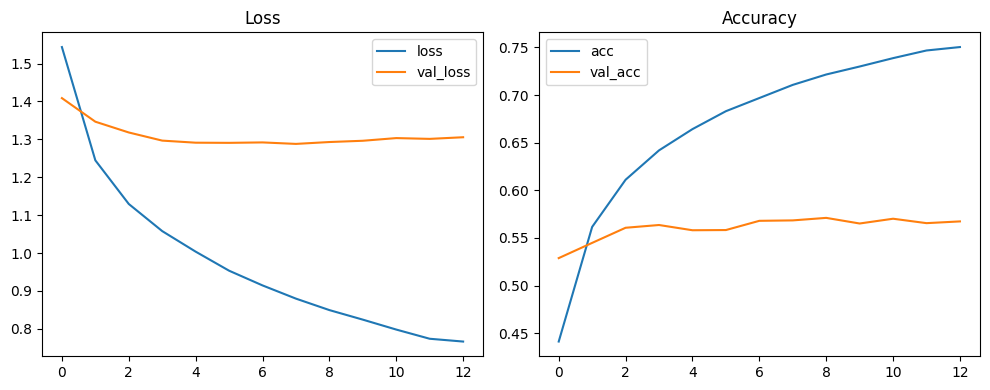

[Epoch 13] metc mobilenetv2 test metrics: {'loss': 1.4123601913452148, 'compile_metrics': 0.5235156416893005}


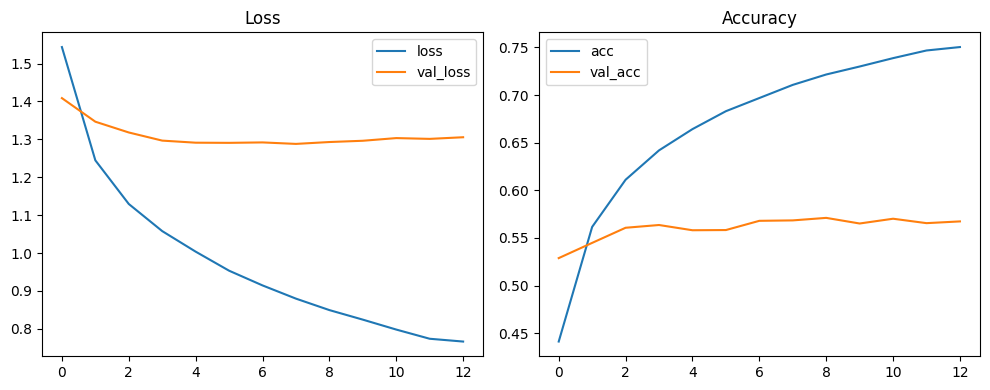

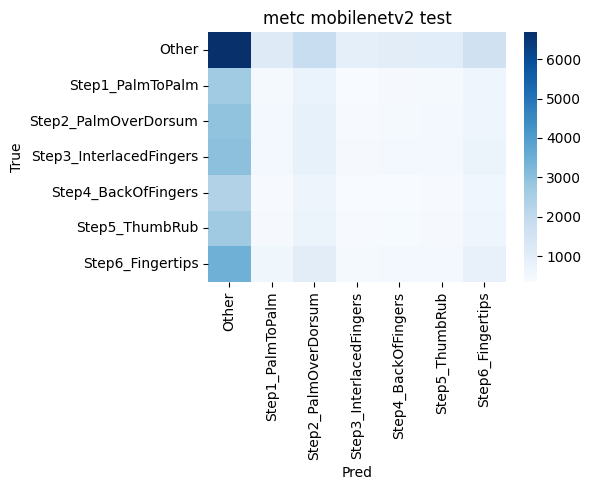

[Epoch 13] metc mobilenetv2 test+aug metrics: {'loss': 1.5770058631896973, 'compile_metrics': 0.4732031226158142}


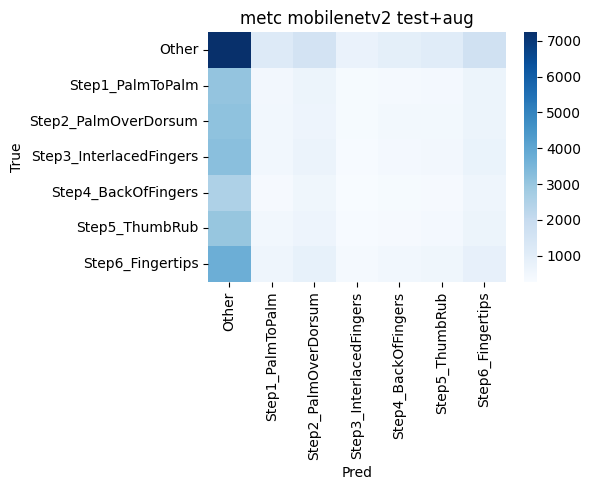

221/221 ━━━━━━━━━━━━━━━━━━━━ 1216s 6s/step - accuracy: 0.7495 - loss: 0.7658 - top2_accuracy: 0.8773 - val_accuracy: 0.5674 - val_loss: 1.3055 - val_top2_accuracy: 0.7415 - learning_rate: 5.0000e-05


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5128 - loss: 1.4094 - top2_accuracy: 0.7100


ValueError: too many values to unpack (expected 2)

In [13]:
def cleanup_dataset_files(dataset_name: str, train_df: pd.DataFrame):
    if CLEANUP_TRAIN:
        for p in train_df['frame_path'].tolist():
            try:
                os.remove(p)
            except FileNotFoundError:
                pass
        train_csv = PROCESSED_DIR / dataset_name / 'train.csv'
        train_aug = PROCESSED_DIR / dataset_name / 'train_aug.csv'
        train_csv.unlink(missing_ok=True)
        train_aug.unlink(missing_ok=True)
    if CLEANUP_RAW:
        shutil.rmtree(RAW_DIR / dataset_name, ignore_errors=True)


def process_dataset(name: str):
    ensure_dataset(name)
    raw_dir = RAW_DIR / name
    validate_raw_dataset(name, raw_dir)
    show_random_video(raw_dir)

    out_dir = PROCESSED_DIR / name
    train_csv = out_dir / 'train.csv'
    val_csv = out_dir / 'val.csv'
    test_csv = out_dir / 'test.csv'
    if not (train_csv.exists() and val_csv.exists() and test_csv.exists()):
        preprocess_dataset(name)
    validate_processed_dataset(out_dir)
    train_df = pd.read_csv(train_csv)
    val_df = pd.read_csv(val_csv)
    test_df = pd.read_csv(test_csv)

    show_random_samples(train_df, title=f"{name} samples")
    show_augmented_samples(train_df, n=12)

    if USE_OFFLINE_AUGMENT:
        aug_dir = out_dir / 'augmented'
        train_df = offline_augment_train(train_df, aug_dir)
        train_df.to_csv(out_dir / 'train_aug.csv', index=False)

    for model_name in MODELS:
        if model_name in AVAILABLE_FRAME_MODELS:
            train_and_eval_frame(model_name, train_df, val_df, test_df, name)
        elif model_name in AVAILABLE_SEQUENCE_MODELS:
            train_and_eval_sequence(model_name, train_df, val_df, test_df, name)
        else:
            print('Unknown model', model_name)

    cleanup_dataset_files(name, train_df)


print('Starting training loop...')
for ds in DATASETS:
    process_dataset(ds)
